In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
#importing the required libraries
from pathlib import Path
from keras.preprocessing import image
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import preprocess_input
from keras.layers import Dense,Flatten,Dropout
from keras import Model
from keras.preprocessing.image import ImageDataGenerator
import math
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from sklearn.metrics import classification_report,precision_score,recall_score
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [5]:
#importing the data and setting up the directories
data_dir=Path('/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray')
train_dir=data_dir/'train'
test_dir=data_dir/'test'
val_dir=data_dir/'val'

The Dataframes for training, testing and validation sets are prepared in the next few cells
The dataframe has 2 columns. Column 1 has the path of the image, and Column has its corresponding category(Normal or Pneumonia)

In [9]:
#creating a dataframe for training data
normal_training_dir=train_dir/'NORMAL'
pneumonia_training_dir=train_dir/'PNEUMONIA'

normal_cases=normal_training_dir.glob('*.jpeg')
pneumonia_cases=normal_training_dir.glob('*.jpeg')


train_data=[]
for img in normal_cases:
    train_data.append((img,0))
    
for img in pneumonia_cases:
    train_data.append((img,1))
    
train_data=pd.DataFrame(train_data,columns=['image','label'],index=None)
train_data=train_data.sample(frac=1).reset_index(drop=True)



In [ ]:
#creating the dataframe for testing data
normal_test_dir=test_dir/'NORMAL'
pneumonia_test_dir=test_dir/'PNEUMONIA'

normal_cases=normal_test_dir.glob('*.jpeg')
pneumonia_cases=pneumonia_test_dir.glob('*.jpeg')

test_data=[]
for img in normal_cases:
    test_data.append((img,0))
for img in pneumonia_cases:
    test_data.append((img,1))

    
test_data=pd.DataFrame(test_data,columns=['image','label'],index=None)
test_data=test_data.sample(frac=1).reset_index(drop=True)



In [15]:
#creating the dataframe for validation data
normal_val_dir=val_dir/'NORMAL'
pneumonia_val_dir=val_dir/'PNEUMONIA'

normal_cases=normal_val_dir.glob('*.jpeg')
pneumonia_cases=normal_val_dir.glob('*.jpeg')


val_data=[]
for img in normal_cases:
    val_data.append((img,0))
    
for img in pneumonia_cases:
    val_data.append((img,1))
    
val_data=pd.DataFrame(val_data,columns=['image','label'],index=None)
val_data=val_data.sample(frac=1).reset_index(drop=True)


In [16]:
#training using vgg16

#downloading the model first
model=VGG19(weights='imagenet',include_top=False,input_shape=(150,150,3))
model.summary()

#converting the training data to list
training_data=train_data['image'].tolist()
training_label=train_data['label'].tolist()    

80142336/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

In [17]:
#converting testing data to list
testing_data=test_data['image'].tolist()
testing_label=test_data['label'].tolist()   

In [18]:
#freezing the vgg16 pretrained layers
for layer in model.layers:
    layer.trainable=False

In [19]:
#Adding Dense Layers to VGG16
layer=model.get_layer('block5_pool')
x=Flatten()(layer.output)
x=Dense(1024,activation='relu')(x)
x=Dropout(0.2)(x)
x=Dense(512,activation='relu')(x)
x=Dropout(0.2)(x)
x=Dense(256,activation='relu')(x) 
x=Dropout(0.1)(x)
x=Dense(1,activation='sigmoid')(x)

In [20]:
#preparing the VGG16+Dense_Layers Model
model_prepared=Model(model.input,x)

In [21]:
#viewing model summary with all the layers (pretrained+Dense)
model_prepared.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0   

In [22]:
#compiling the model with Adam Optimizer and binary crossentropy loss
model_prepared.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['acc'])

In [23]:
#setting up the Image Data Generators to get the images from dataframe
training_gen=ImageDataGenerator(zoom_range=0.2,shear_range=0.2,rescale=1./255,horizontal_flip=True)
testing_gen=ImageDataGenerator(rescale=1./255)
valid_gen=ImageDataGenerator(rescale=1./255)

training_data=training_gen.flow_from_directory(directory=train_dir,
                                             target_size=(150,150),
                                             batch_size=32,
                                             class_mode='binary')
testing_data=testing_gen.flow_from_directory(directory=test_dir,
                                             target_size=(150,150),
                                             batch_size=32,
                                             class_mode='binary',
                                             shuffle=False)
validation_data=valid_gen.flow_from_directory(directory=val_dir,
                                             target_size=(150,150),
                                             batch_size=32,
                                             class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [24]:
#getting the labels from testing data to check for accuracy(will use it later in the notebook)
number_of_examples = len(testing_data.filenames)
number_of_generator_calls = math.ceil(number_of_examples / (1.0 * 32)) 
# 1.0 above is to skip integer division

test_labels = []

for i in range(0,int(number_of_generator_calls)):
    test_labels.extend(np.array(testing_data[i][1]))


In [25]:
#appling the learning rate reducer and early stopping to prevent overfitting 
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.3, patience=2, verbose=2, mode='max')
early_stopping=EarlyStopping(patience=5,monitor='val_acc',verbose=2,mode='max')

#running the model
model_prepared.fit(training_data,validation_data=validation_data,callbacks=[early_stopping,lr_reduce],epochs=10)

Epoch 1/10
163/163 [==============================] - 198s 1s/step - loss: 0.2790 - acc: 0.8786 - val_loss: 0.4373 - val_acc: 0.8750
Epoch 2/10
163/163 [==============================] - 168s 1s/step - loss: 0.1758 - acc: 0.9247 - val_loss: 0.5332 - val_acc: 0.7500
Epoch 3/10
163/163 [==============================] - 163s 1s/step - loss: 0.1580 - acc: 0.9396 - val_loss: 0.7727 - val_acc: 0.7500

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/10
163/163 [==============================] - 163s 999ms/step - loss: 0.1409 - acc: 0.9436 - val_loss: 0.4810 - val_acc: 0.7500
Epoch 5/10
163/163 [==============================] - 167s 1s/step - loss: 0.1280 - acc: 0.9517 - val_loss: 0.4970 - val_acc: 0.8125

Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
Epoch 6/10
163/163 [==============================] - 164s 1s/step - loss: 0.1191 - acc: 0.9536 - val_loss: 0.5296 - val_acc: 0.8125
Epoch 00006: early stopping


In [26]:
#getting the scores from testing data
scores=model_prepared.evaluate_generator(testing_data)
print("Test Accuracy: ",scores[1])

Test Accuracy:  0.8894230723381042


In [27]:
#using the testing labels to get a better report
y_pred=model_prepared.predict_generator(testing_data)
print(classification_report(test_labels,np.round(y_pred)))

              precision    recall  f1-score   support

         0.0       0.97      0.73      0.83       234
         1.0       0.86      0.98      0.92       390

    accuracy                           0.89       624
   macro avg       0.91      0.86      0.87       624
weighted avg       0.90      0.89      0.89       624



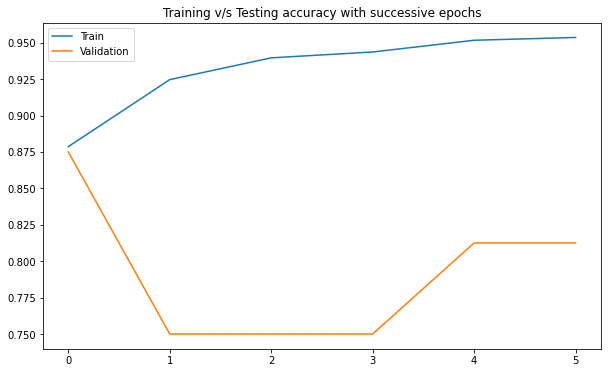

In [28]:
plt.figure(figsize = (10,6))
plt.plot(model_prepared.history.history['acc'],label = 'Train')
plt.plot(model_prepared.history.history['val_acc'],label = 'Validation')
plt.title('Training v/s Testing accuracy with successive epochs')
plt.legend()

In [29]:
print(model_prepared.history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


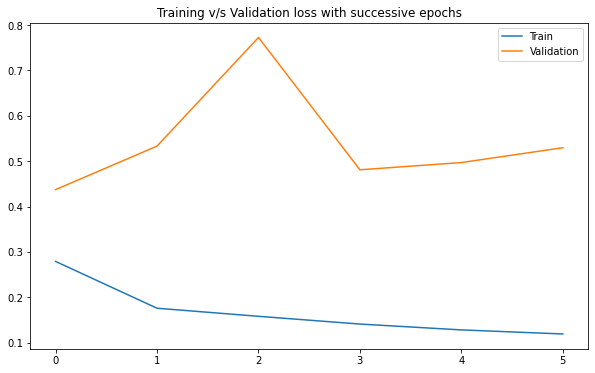

In [30]:
plt.figure(figsize = (10,6))
plt.plot(model_prepared.history.history['loss'],label = 'Train')
plt.plot(model_prepared.history.history['val_loss'],label = 'Validation')
plt.title('Training v/s Validation loss with successive epochs')
plt.legend()